In [1]:
import pandas as pd
import os
import re
import numpy as np

In [2]:
def processar_arquivo(caminho_entrada, chunk_size=100000):
    # Lê o arquivo CSV em pedaços (chunks)
    chunks = pd.read_csv(caminho_entrada, usecols=lambda col: 'Unnamed' not in col, dtype=str, chunksize=chunk_size,sep=';' )

    lista_df = []  # Lista para armazenar os pedaços processados
    for df_chunk in chunks:
        # Renomear as colunas no chunk atual
        colunas_renomeadas = [renomear_colunas(coluna.split(" : ")[0]) for coluna in df_chunk.columns]
        mapeamento_colunas = dict(zip(df_chunk.columns, colunas_renomeadas))
        df_renomeado = df_chunk.rename(columns=mapeamento_colunas)

        # Remover linhas e colunas completamente vazias
        df_final = remover_linhas_colunas_vazias(df_renomeado)

        # Converte colunas para o tipo 'category' onde aplicável
        df_final = converter_para_categorias(df_final)

        lista_df.append(df_final)

    # Concatenar todos os pedaços processados em um único DataFrame
    df_consolidado = pd.concat(lista_df, ignore_index=True)

    # Libera a memória das listas intermediárias
    del lista_df

    return df_consolidado
def renomear_colunas(nome_coluna):
    # Códigos das perguntas
    codigos_perguntas = ['P2', 'P2a', 'P2b', 'P3A', 'P3B', 'P4B', 'P2Ca', 'P2Cb']

    # Para os padrões de pergunta e atributo
    padrao_pergunta = re.compile(r'([A-Za-z]+)_([0-9]+)_([0-9]+)_([0-9]+)', re.IGNORECASE)
    match_pergunta = padrao_pergunta.match(nome_coluna)
    if match_pergunta:
        tipo_pergunta, codigo_categoria, codigo_marca, _ = match_pergunta.groups()
        if tipo_pergunta in codigos_perguntas:
            if tipo_pergunta in ['P2Ca', 'P2Cb']:
                codigo_atributo = codigo_marca
                codigo_marca = codigo_categoria
                if tipo_pergunta == 'P2Cb':
                    codigo_atributo = str(int(codigo_atributo) + 12)
                novo_nome = f'CAT{codigo_categoria}_{tipo_pergunta}_AT{codigo_atributo}_M{codigo_marca}'
            else:
                novo_nome = f'CAT{codigo_categoria}_{tipo_pergunta}_M{codigo_marca}'
            return novo_nome
    return nome_coluna

def remover_linhas_colunas_vazias(df):
    df = df.dropna(how='all')  # Remover linhas completamente vazias
    df = df.dropna(axis=1, how='all')  # Remover colunas completamente vazias
    return df

def converter_para_categorias(df):
    for col in df.columns:
        if df[col].dtype == 'object':  # Se a coluna for do tipo 'object' (texto)
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:  # Se menos de 50% dos valores forem únicos
                df[col] = df[col].astype('category')
    return df

In [3]:
df_consolidado=processar_arquivo("C:/Users/hynishisaki/Downloads/NLS/NLS2023_Categorias11a15.csv")

     responseid respid P2_1101_11 P2_1102_11 P2_1103_11 P2_1104_11 P2_1105_11  \
0             1      1        NaN        NaN        NaN        NaN        NaN   
1             2      2        NaN        NaN        NaN        NaN        NaN   
2             3      3        NaN        NaN        NaN        NaN        NaN   
3             4      4        NaN        NaN        NaN        NaN        NaN   
4             5      5        NaN        NaN        NaN        NaN        NaN   
...         ...    ...        ...        ...        ...        ...        ...   
3449      10954  24233          0          0          0          0          0   
3450      11026  11685          1          0          0          0          0   
3451      11035  11694          0          0          0          1          0   
3452      11036  11697          1          1          0          0          0   
3453      11062  11724          1          0          0          0          0   

     P2_1106_11 P2_1107_11 

In [4]:
df_attribute = df_consolidado.columns

df_version2 = pd.DataFrame(df_attribute, columns = ['Column_A'])

df_version2['Question'] = (np.where(
            df_version2['Column_A'].str.split('_').str[0]=='P2Ca',df_version2['Column_A'].str.split('_').str[0]+'_'+df_version2['Column_A'].str.split('_').str[1],
            np.where(df_version2['Column_A'].str.split('_').str[0]=='P2Cb',df_version2['Column_A'].str.split('_').str[0]+'_'+df_version2['Column_A'].str.split('_').str[1],
            np.where(df_version2['Column_A'].str.contains('_'),df_version2['Column_A'].str.split('_').str[0],
            df_version2['Column_A']))))

df_version2['Brand'] = (np.where(
            df_version2['Column_A'].str.split('_').str[0]=='P2Ca',df_version2['Column_A'].str.split('_').str[2],
            np.where(df_version2['Column_A'].str.split('_').str[0]=='P2Cb',df_version2['Column_A'].str.split('_').str[2],
            np.where(df_version2['Column_A'].str.contains('_'),df_version2['Column_A'].str.split('_').str[1],
            df_version2['Column_A']))))

df_version2['Category'] = (np.where(df_version2['Column_A'].str.contains('_'),
                  df_version2['Column_A'].str.split('_').str[2],
                  df_version2['Column_A']))

print(df_version2)

         Column_A    Question       Brand    Category
0      responseid  responseid  responseid  responseid
1          respid      respid      respid      respid
2      P2_1101_11          P2        1101          11
3      P2_1102_11          P2        1102          11
4      P2_1103_11          P2        1103          11
...           ...         ...         ...         ...
2450  P4B_1510_15         P4B        1510          15
2451  P4B_1511_15         P4B        1511          15
2452  P4B_1512_15         P4B        1512          15
2453  P4B_1513_15         P4B        1513          15
2454  P4B_1514_15         P4B        1514          15

[2455 rows x 4 columns]


In [6]:

df1_transposed = df_version2.T 
column_names=list(df_consolidado)
df1_transposed.columns = column_names

result=pd.concat([df_consolidado, df1_transposed])

result_clear = result.dropna(axis=1, how='all') 

print(result_clear)

          responseid  respid  P2_1101_11  P2_1102_11  P2_1103_11  P2_1104_11  \
0                  1       1         NaN         NaN         NaN         NaN   
1                  2       2         NaN         NaN         NaN         NaN   
2                  3       3         NaN         NaN         NaN         NaN   
3                  4       4         NaN         NaN         NaN         NaN   
4                  5       5         NaN         NaN         NaN         NaN   
...              ...     ...         ...         ...         ...         ...   
3453           11062   11724           1           0           0           0   
Column_A  responseid  respid  P2_1101_11  P2_1102_11  P2_1103_11  P2_1104_11   
Question  responseid  respid          P2          P2          P2          P2   
Brand     responseid  respid        1101        1102        1103        1104   
Category  responseid  respid          11          11          11          11   

          P2_1105_11  P2_1106_11  P2_11

In [7]:
filter_col=result_clear.filter(regex=("P2_.*"))
brands=filter_col.loc['Brand']
brands_unique=set(brands)
brands_unique.remove('99')

filter_row=result_clear.loc['Question']
questions_unique=set(filter_row)



df_agg=pd.DataFrame(columns=['brand',
                             'responseid',  
                             'respid',
                             "P2a",
    "P2b",
    "P2Ca_1",
    "P2Ca_2",
    "P2Ca_3",
    "P2Ca_4",
    "P2Ca_5",
    "P2Ca_6",
    "P2Ca_7",
    "P2Ca_8",
    "P2Ca_9",
    "P2Ca_10",
    "P2Ca_11",
    "P2Ca_12",
    "P2Cb_1",
    "P2Cb_2",
    "P2Cb_3",
    "P2Cb_4",
    "P2Cb_5",
    "P2Cb_6",
    "P2Cb_7",
    "P2Cb_8",
    "P2Cb_9",
    "P2Cb_10",
    "P2Cb_11",
    "P2Cb_12"
                            ])


for colum_ident in brands_unique:
    selected = result_clear.filter(regex=colum_ident)
    selected.columns = selected.loc['Question']
    intermediary=selected.assign(brand=colum_ident)
    intermediary.index = ['R' + str(i + 1) for i in range(len(df_agg), len(df_agg) + len(intermediary))]
    df_agg=pd.concat([df_agg, intermediary], sort=False, ignore_index=True)
    intermediary=[]


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [8]:
nps = df_agg

#diary
# List of brand numbers to keep
valid_brand_numbers = [
    '1401',
    '1402',
    '1403',
    '1404',
    '1405',
    '1406',
    '1407',
    '1408',
    '1409',
    '1410',
    '1411',
    '1412',
    '1413',
    '1414',
    '1415',
    '1416',
    '1417',
    '1418',
    '1419'
]

# Filter rows in 'nps' where 'brand' is in the valid_brand_numbers
nps = nps[nps['brand'].isin(valid_brand_numbers)]

# Display the updated 'nps' DataFrame
nps


,brand,responseid,respid,P2a,P2b,P2Ca_1,P2Ca_2,P2Ca_3,P2Ca_4,P2Ca_5,...,P2Cb_7,P2Cb_8,P2Cb_9,P2Cb_10,P2Cb_11,P2Cb_12,P2,P3A,P3B,P4B
0,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235139,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235140,1401,NaN,NaN,P2a_1401_14,NaN,P2Ca_1_1401_14,P2Ca_2_1401_14,P2Ca_3_1401_14,P2Ca_4_1401_14,P2Ca_5_1401_14,...,P2Cb_7_1401_14,P2Cb_8_1401_14,P2Cb_9_1401_14,P2Cb_10_1401_14,P2Cb_11_1401_14,P2Cb_12_1401_14,P2_1401_14,P3A_1401_14,P3B_1401_14,P4B_1401_14
235141,1401,NaN,NaN,P2a,NaN,P2Ca_1,P2Ca_2,P2Ca_3,P2Ca_4,P2Ca_5,...,P2Cb_7,P2Cb_8,P2Cb_9,P2Cb_10,P2Cb_11,P2Cb_12,P2,P3A,P3B,P4B
235142,1401,NaN,NaN,1401,NaN,1401,1401,1401,1401,1401,...,1401,1401,1401,1401,1401,1401,1401,1401,1401,1401


In [9]:
nps = nps.drop(columns=['P2b'])
nps = nps.drop(columns=['responseid'])
nps = nps.drop(columns=['respid'])
nps = nps.drop(columns=['P3A'])
nps = nps.drop(columns=['P3B'])
nps = nps.drop(columns=['P4B'])
nps = nps.drop(columns=['P2'])
nps

,brand,P2a,P2Ca_1,P2Ca_2,P2Ca_3,P2Ca_4,P2Ca_5,P2Ca_6,P2Ca_7,P2Ca_8,...,P2Cb_3,P2Cb_4,P2Cb_5,P2Cb_6,P2Cb_7,P2Cb_8,P2Cb_9,P2Cb_10,P2Cb_11,P2Cb_12
0,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235139,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235140,1401,P2a_1401_14,P2Ca_1_1401_14,P2Ca_2_1401_14,P2Ca_3_1401_14,P2Ca_4_1401_14,P2Ca_5_1401_14,P2Ca_6_1401_14,P2Ca_7_1401_14,P2Ca_8_1401_14,...,P2Cb_3_1401_14,P2Cb_4_1401_14,P2Cb_5_1401_14,P2Cb_6_1401_14,P2Cb_7_1401_14,P2Cb_8_1401_14,P2Cb_9_1401_14,P2Cb_10_1401_14,P2Cb_11_1401_14,P2Cb_12_1401_14
235141,1401,P2a,P2Ca_1,P2Ca_2,P2Ca_3,P2Ca_4,P2Ca_5,P2Ca_6,P2Ca_7,P2Ca_8,...,P2Cb_3,P2Cb_4,P2Cb_5,P2Cb_6,P2Cb_7,P2Cb_8,P2Cb_9,P2Cb_10,P2Cb_11,P2Cb_12
235142,1401,1401,1401,1401,1401,1401,1401,1401,1401,1401,...,1401,1401,1401,1401,1401,1401,1401,1401,1401,1401


In [10]:
nps = nps.apply(pd.to_numeric, errors='coerce')
nps

,brand,P2a,P2Ca_1,P2Ca_2,P2Ca_3,P2Ca_4,P2Ca_5,P2Ca_6,P2Ca_7,P2Ca_8,...,P2Cb_3,P2Cb_4,P2Cb_5,P2Cb_6,P2Cb_7,P2Cb_8,P2Cb_9,P2Cb_10,P2Cb_11,P2Cb_12
0,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235139,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235140,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235141,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235142,1401,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,...,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0,1401.0


In [11]:
# we will drop lines that have NaN's in every variable
columns_to_check = ['P2a', 'P2Ca_1', 'P2Ca_2', 'P2Ca_3', 'P2Ca_4', 'P2Ca_5', 'P2Ca_6', 'P2Ca_7', 'P2Ca_8', 'P2Ca_9', 'P2Ca_10', 'P2Ca_11', 'P2Ca_12', 'P2Cb_1', 'P2Cb_2', 'P2Cb_3', 'P2Cb_4', 'P2Cb_5', 'P2Cb_6', 'P2Cb_7', 'P2Cb_8', 'P2Cb_9', 'P2Cb_10', 'P2Cb_11', 'P2Cb_12']

# Drop rows where all specified columns have NaN values
nps = nps.dropna(subset=columns_to_check, how='all')

columns_to_check = ['P2Ca_1', 'P2Ca_2', 'P2Ca_3', 'P2Ca_4', 'P2Ca_5', 'P2Ca_6', 'P2Ca_7', 'P2Ca_8', 'P2Ca_9', 'P2Ca_10', 'P2Ca_11', 'P2Ca_12', 'P2Cb_1', 'P2Cb_2', 'P2Cb_3', 'P2Cb_4', 'P2Cb_5', 'P2Cb_6', 'P2Cb_7', 'P2Cb_8', 'P2Cb_9', 'P2Cb_10', 'P2Cb_11', 'P2Cb_12']
nps = nps.dropna(subset=columns_to_check, how='all')


nps.drop(nps.loc[nps['P2Ca_1']>1].index, inplace=True)
nps.drop(nps.loc[nps['P2a']=='NaN'].index, inplace=True)
nps.fillna(0)

# Display the updated DataFrame
print(nps)


        brand   P2a  P2Ca_1  P2Ca_2  P2Ca_3  P2Ca_4  P2Ca_5  P2Ca_6  P2Ca_7  \
77       1405   9.0     0.0     0.0     1.0     0.0     0.0     0.0     1.0   
97       1405   9.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
324      1405   8.0     1.0     1.0     0.0     0.0     0.0     1.0     0.0   
346      1405   9.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
359      1405  10.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
...       ...   ...     ...     ...     ...     ...     ...     ...     ...   
234692   1401   3.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
234698   1401   7.0     0.0     1.0     1.0     0.0     0.0     1.0     0.0   
234699   1401  10.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
234720   1401  10.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0   
234729   1401  10.0     1.0     1.0     0.0     0.0     0.0     0.0     0.0   

        P2Ca_8  ...  P2Cb_3  P2Cb_4  P2Cb_5  P2Cb_6

In [12]:
# Iterar sobre todas las columnas para verificar su tipo y valores únicos
for column in nps.columns:
    # Verificar si la columna es numérica
    if nps[column].dtype.kind in 'biufc':  # b: boolean, i: integer, u: unsigned integer, f: float, c: complex
        # Verificar si la columna solo contiene 0s y 1s
        unique_values = nps[column].dropna().unique()
        if set(unique_values).issubset({0, 1}):
            print(f"La columna '{column}' es numérica y solo contiene 0s y 1s.")
        else:
            print(f"La columna '{column}' es numérica pero contiene valores distintos de 0 y 1.")
    else:
        print(f"La columna '{column}' no es numérica.")

La columna 'brand' es numérica pero contiene valores distintos de 0 y 1.
La columna 'P2a' es numérica pero contiene valores distintos de 0 y 1.
La columna 'P2Ca_1' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_2' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_3' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_4' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_5' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_6' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_7' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_8' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_9' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_10' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_11' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_12' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_1' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_2' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_3' es numérica y solo contiene 0s y 1s

In [13]:
validate=nps

##validate['P2a'] = validate['P2a'].astype('int')

validate['P2a']=np.where(
    np.isin(validate['P2a'], [0,1,2,3,4,5,6,7,8]),0,
    np.where(np.isin(validate['P2a'], [9,10]),1,'NaN')
    )

validate

,brand,P2a,P2Ca_1,P2Ca_2,P2Ca_3,P2Ca_4,P2Ca_5,P2Ca_6,P2Ca_7,P2Ca_8,...,P2Cb_3,P2Cb_4,P2Cb_5,P2Cb_6,P2Cb_7,P2Cb_8,P2Cb_9,P2Cb_10,P2Cb_11,P2Cb_12
77,1405,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
97,1405,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
324,1405,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
346,1405,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
359,1405,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234692,1401,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
234698,1401,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
234699,1401,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234720,1401,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [15]:
cols = [
    "P2a",
    "P2Ca_1",
    "P2Ca_2",
    "P2Ca_3",
    "P2Ca_4",
    "P2Ca_5",
    "P2Ca_6",
    "P2Ca_7",
    "P2Ca_8",
    "P2Ca_9",
    "P2Ca_10",
    "P2Ca_11",
    "P2Ca_12",
    "P2Cb_1",
    "P2Cb_2",
    "P2Cb_3",
    "P2Cb_4",
    "P2Cb_5",
    "P2Cb_6",
    "P2Cb_7",
    "P2Cb_8",
    "P2Cb_9",
    "P2Cb_10",
    "P2Cb_11",
    "P2Cb_12"
]

feature_cols = [
    "P2Ca_1",
    "P2Ca_2",
    "P2Ca_3",
    "P2Ca_4",
    "P2Ca_5",
    "P2Ca_6",
    "P2Ca_7",
    "P2Ca_8",
    "P2Ca_9",
    "P2Ca_10",
    "P2Ca_11",
    "P2Ca_12",
    "P2Cb_1",
    "P2Cb_2",
    "P2Cb_3",
    "P2Cb_4",
    "P2Cb_5",
    "P2Cb_6",
    "P2Cb_7",
    "P2Cb_8",
    "P2Cb_9",
    "P2Cb_10",
    "P2Cb_11",
    "P2Cb_12"
]

clean_col=[
    "P2Ca_1",
    "P2Ca_2",
    "P2Ca_3",
    "P2Ca_4",
    "P2Ca_5",
    "P2Ca_6",
    "P2Ca_7",
    "P2Ca_8",
    "P2Ca_9",
    "P2Ca_10",
    "P2Ca_11",
    "P2Ca_12",
    "P2Cb_1",
    "P2Cb_2",
    "P2Cb_3",
    "P2Cb_4",
    "P2Cb_5",
    "P2Cb_6",
    "P2Cb_7",
    "P2Cb_8",
    "P2Cb_9",
    "P2Cb_10",
    "P2Cb_11",
    "P2Cb_12"
]

clean_df=validate[clean_col] # Features
clear=validate[cols]
X = validate[feature_cols] # Features
y = validate["P2a"] # Target variable

In [16]:
df=clear

import numpy as np
from scipy import stats
import pandas as pd

# Filter out non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(numeric_cols)

# Inicializar un diccionario para almacenar los resultados de la correlación
correlation_results = {}

# Calculate Pearson correlation for numeric columns only
for coluna in numeric_cols:
    # Make sure to drop NaN values in both columns being compared
    filtered_df = df.dropna(subset=[coluna, 'P2a'])
    if not filtered_df.empty:
        correlation, p_value = stats.pearsonr(filtered_df[coluna], filtered_df["P2a"])
        print(coluna, correlation)
        correlation_results[coluna] = p_value #almacenar el p-value
#umbral de significancia estadistica
p_value_treshold = 0.05

#seleccionar y mostrar variables estadísticamente significativas del dataset
significant_variables = [var for var, p_value in correlation_results.items() if p_value < p_value_treshold]
print("Variables estadísticamente significativas:", significant_variables)


['P2Ca_1', 'P2Ca_2', 'P2Ca_3', 'P2Ca_4', 'P2Ca_5', 'P2Ca_6', 'P2Ca_7', 'P2Ca_8', 'P2Ca_9', 'P2Ca_10', 'P2Ca_11', 'P2Ca_12', 'P2Cb_1', 'P2Cb_2', 'P2Cb_3', 'P2Cb_4', 'P2Cb_5', 'P2Cb_6', 'P2Cb_7', 'P2Cb_8', 'P2Cb_9', 'P2Cb_10', 'P2Cb_11', 'P2Cb_12']


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

In [17]:
#variables no significativas estadisticamente
p_value_threshold = 0.05
non_significant_variables = [var for var, p_value in correlation_results.items() if p_value >= p_value_threshold]
print("Variables no estadísticamente significativas:", non_significant_variables)

Variables no estadísticamente significativas: []


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [vif(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

    feature       VIF
0    P2Ca_1  4.506882
1    P2Ca_2  4.423821
2    P2Ca_3  2.664861
3    P2Ca_4  2.515823
4    P2Ca_5  3.392430
5    P2Ca_6  4.326640
6    P2Ca_7  3.882719
7    P2Ca_8  4.317343
8    P2Ca_9  3.693762
9   P2Ca_10  2.943235
10  P2Ca_11  4.724478
11  P2Ca_12  3.923208
12   P2Cb_1  3.899219
13   P2Cb_2  2.845538
14   P2Cb_3  4.673066
15   P2Cb_4  3.207270
16   P2Cb_5  3.727364
17   P2Cb_6  3.381228
18   P2Cb_7  3.625433
19   P2Cb_8  2.861029
20   P2Cb_9  3.451853
21  P2Cb_10  3.511064
22  P2Cb_11  3.623975
23  P2Cb_12  3.185434


In [19]:
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Manejar valores nulos
df_clean = df.dropna()  # Eliminar filas con valores nulos


In [20]:
# Iterar sobre todas las columnas para verificar su tipo y valores únicos
for column in df_clean.columns:
    # Verificar si la columna es numérica
    if df_clean[column].dtype.kind in 'biufc':  # b: boolean, i: integer, u: unsigned integer, f: float, c: complex
        # Verificar si la columna solo contiene 0s y 1s
        unique_values = df_clean[column].dropna().unique()
        if set(unique_values).issubset({0, 1}):
            print(f"La columna '{column}' es numérica y solo contiene 0s y 1s.")
        else:
            print(f"La columna '{column}' es numérica pero contiene valores distintos de 0 y 1.")
    else:
        print(f"La columna '{column}' no es numérica.")

La columna 'P2a' no es numérica.
La columna 'P2Ca_1' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_2' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_3' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_4' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_5' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_6' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_7' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_8' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_9' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_10' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_11' es numérica y solo contiene 0s y 1s.
La columna 'P2Ca_12' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_1' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_2' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_3' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_4' es numérica y solo contiene 0s y 1s.
La columna 'P2Cb_5' es numérica y solo contiene 0s y

In [21]:
# Ahora puedes usar df_clean para el test de Bartlett
chi_square_value, p_value = calculate_bartlett_sphericity(df_clean)
print(f"Valor Chi-Cuadrado: {chi_square_value}")
print(f"Valor p: {p_value}")

TypeError: unsupported operand type(s) for -: 'str' and 'float'

Con el resultado Valor Chi-Cuadrado: 11449.385938010599 nos indica que existe una correlación significativa entre las variables.
El resultado 0 de p, nos indica que los resultados del test son estadisticamente significativo, osea, que existe al menos una de las variables está correlacionada.

In [23]:
fa = FactorAnalyzer(rotation='varimax',n_factors =4)
fa.fit(X,y)
# Check Eigenvalues
ev, _ = fa.get_eigenvalues()
for i, eigenvalue in enumerate(ev):
    explanation = "Factor importante (explica una parte significativa de la varianza)" if eigenvalue > 1 else "Factor menos importante (explica menos varianza que una variable por sí sola)"
    print(f"Valor propio para el Factor {i+1}: {eigenvalue:.4f} - {explanation}")

Valor propio para el Factor 1: 10.7227 - Factor importante (explica una parte significativa de la varianza)
Valor propio para el Factor 2: 1.3554 - Factor importante (explica una parte significativa de la varianza)
Valor propio para el Factor 3: 1.0658 - Factor importante (explica una parte significativa de la varianza)
Valor propio para el Factor 4: 0.7988 - Factor menos importante (explica menos varianza que una variable por sí sola)
Valor propio para el Factor 5: 0.7601 - Factor menos importante (explica menos varianza que una variable por sí sola)
Valor propio para el Factor 6: 0.6610 - Factor menos importante (explica menos varianza que una variable por sí sola)
Valor propio para el Factor 7: 0.6567 - Factor menos importante (explica menos varianza que una variable por sí sola)
Valor propio para el Factor 8: 0.6343 - Factor menos importante (explica menos varianza que una variable por sí sola)
Valor propio para el Factor 9: 0.5883 - Factor menos importante (explica menos varianza 

ES

Para entender este resultado:

Valores propios:
- Cada valor propio mide la cantidad de varianza que se atribuye a cada factor. Matemáticamente, un valor propio indica cuánta varianza en las respuestas de las variables puede ser explicada por ese factor en particular.

"explica una parte significativa de la varianza":
- Un valor propio mayor que 1 indica que el factor correspondiente explica más varianza que una sola variable promedio en el dataset.
- Esto se debe a que en promedio, cada variable en el análisis factorial tiene una varianza de 1. Por lo tanto, un valor propio mayor que 1 significa que ese factor capta más información (varianza) que la contribución promedio de una sola variable.

"explica menos varianza que una variable por si sola":
- Por el contrario al anterior, un valor propio menor o igual a 1 indica que el factor correspondiente explica menos o igual cantidad de varianza que una sola variable promedio.
-  En´terminos prácticos, esto significa que el factor no está capturando suficiente información única o significativa de las variables y, por lo tanto, podría no ser útil para retener en el análisis.

Criterio de Kaiser:
- Esta es una regla práctica en el análisis factorial que sugiere retener solo aquellos factores cuyos valores propios sean mayores que 1.
- El fundamento matemático detrás de esta regla es que deseas retener factores que aportan más a explicar la varianza en los datos que una sola variable promedio.

BR
Valores Próprios (Eigenvalues):

- Na análise fatorial, calculamos os valores próprios da matriz de correlação das variáveis.
- Cada valor próprio mede a quantidade de variância que é atribuída a cada fator. Matematicamente, um valor próprio indica quanto da variância nas respostas das variáveis pode ser explicada por esse fator em particular.

Explica uma Parte Significativa da Variância:

- Um valor próprio maior do que 1 indica que o fator correspondente explica mais variância do que uma única variável média no seu conjunto de dados.
- Isso se deve ao fato de que, em média, cada variável em uma análise fatorial (com padronização) tem uma variância de 1. Portanto, um valor próprio maior do que 1 significa que esse fator captura mais informação (variância) do que a contribuição média de uma única variável.

Explica Menos Variância do que uma Variável por Si Só:

- Por outro lado, um valor próprio de 1 ou menos indica que o fator correspondente explica menos ou igual quantidade de variância do que uma única variável média.
- Em termos práticos, isso significa que o fator não está capturando informação única ou significativa suficiente das variáveis e, portanto, poderia não ser útil para reter na análise.

Critério de Kaiser:
- Esta é uma regra prática na análise fatorial que sugere reter apenas aqueles fatores cujos valores próprios sejam maiores do que 1.
O fundamento matemático por trás desta regra é que você deseja reter fatores que contribuem mais para explicar a variância nos dados do que uma única variável média.

In [24]:
factors = pd.DataFrame(
    fa.loadings_,
    columns=['Factor1', 'Factor2', 'Factor3', 'Factor4'],
    index=clean_df.columns
)

# Imprimir las cargas factoriales con una descripción
print("Cargas Factoriales:\n")
print(factors)

# Añadir una explicación general
print("\nExplicación:")
print("Cada fila representa una variable original y cada columna un factor.")
print("Los valores son las cargas factoriales, que indican cuánto contribuye cada variable a cada factor.")
print("Valores más altos significan una contribución más fuerte a ese factor específico.")


Cargas Factoriales:

          Factor1   Factor2   Factor3   Factor4
P2Ca_1   0.695917  0.132831  0.206653  0.152671
P2Ca_2   0.551949  0.316055  0.251464  0.135133
P2Ca_3   0.368028  0.148763  0.309778  0.483784
P2Ca_4   0.290723  0.098074  0.535373  0.217208
P2Ca_5   0.358846  0.279324  0.530691  0.141117
P2Ca_6   0.625589  0.268424  0.258272  0.166461
P2Ca_7   0.620957  0.187934  0.273185  0.234156
P2Ca_8   0.629017  0.213744  0.243686  0.247897
P2Ca_9   0.505015  0.279944  0.306951  0.191106
P2Ca_10  0.359002  0.342162  0.365020  0.173289
P2Ca_11  0.625452  0.353040  0.182747  0.038946
P2Ca_12  0.465114  0.352333  0.429158  0.012226
P2Cb_1   0.455699  0.458074  0.168257  0.291791
P2Cb_2   0.292789  0.350898  0.263988  0.487667
P2Cb_3   0.506265  0.476314  0.105288  0.213686
P2Cb_4   0.197459  0.476377  0.455671  0.153827
P2Cb_5   0.359671  0.431418  0.347688  0.155604
P2Cb_6   0.226669  0.593941  0.135339  0.064394
P2Cb_7   0.455754  0.421356  0.128870  0.193134
P2Cb_8   0.119021  

In [28]:
# Adicionar uma explicação geral
print("\nExplicação:")
print("Cada linha representa uma variável original e cada coluna um fator.")
print("Os valores são as cargas fatoriais, que indicam o quanto cada variável contribui para cada fator.")
print("Valores mais altos significam uma contribuição mais forte para esse fator específico.")


Explicação:
Cada linha representa uma variável original e cada coluna um fator.
Os valores são as cargas fatoriais, que indicam o quanto cada variável contribui para cada fator.
Valores mais altos significam uma contribuição mais forte para esse fator específico.


In [45]:
from factor_analyzer import FactorAnalyzer

In [24]:
# Seleccionar variables para cada factor basado en las cargas factoriales
threshold = 0.3  # Define tu propio umbral
for factor in range(4):
    factor_loadings = factors.iloc[:, factor]
    selected_variables = factor_loadings[factor_loadings.abs() >= threshold].index.tolist()
    print(f"Variables for Factor {factor+1}: {selected_variables}")


Variables for Factor 1: ['P2Ca_1', 'P2Ca_2', 'P2Ca_6', 'P2Ca_7', 'P2Ca_8', 'P2Ca_9', 'P2Ca_10', 'P2Ca_11', 'P2Ca_12', 'P2Cb_1', 'P2Cb_3', 'P2Cb_5', 'P2Cb_6', 'P2Cb_7', 'P2Cb_11', 'P2Cb_12']
Variables for Factor 2: ['P2Ca_4', 'P2Ca_5', 'P2Ca_12', 'P2Cb_1', 'P2Cb_2', 'P2Cb_4', 'P2Cb_5', 'P2Cb_6', 'P2Cb_7', 'P2Cb_8', 'P2Cb_9', 'P2Cb_10', 'P2Cb_11', 'P2Cb_12']
Variables for Factor 3: ['P2Ca_3', 'P2Ca_4', 'P2Ca_5', 'P2Ca_7', 'P2Ca_9', 'P2Ca_10', 'P2Cb_2']
Variables for Factor 4: ['P2Ca_3', 'P2Ca_7', 'P2Cb_1', 'P2Cb_2', 'P2Cb_7', 'P2Cb_12']


In [22]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

# Función para calcular VIF
def calculate_vif(df_clean, variables):
    vif_data = pd.DataFrame()
    vif_data["variable"] = variables
    vif_data["VIF"] = [variance_inflation_factor(df[variables].values, i) for i in range(len(variables))]
    return vif_data

# Función para seleccionar variables basado en p-value y VIF
def select_variables(df_clean, threshold_vif=5, threshold_pvalue=0.05):
    selected_variables = []

    # Calcula VIF para cada variable
    vif_data = calculate_vif(df_clean, df.columns[:-1]) # Excluyendo la variable objetivo

    # Realiza regresión y obtiene p-values
    model = ols("Y ~ " + " + ".join(df_clean.columns[:-1]), data=df_clean).fit()
    pvalues = model.pvalues

    # Selección basada en VIF y p-value
    for variable in df_clean.columns[:-1]:
        if vif_data[vif_data["variable"] == variable]["VIF"].values[0] < threshold_vif and pvalues[variable] < threshold_pvalue:
            selected_variables.append(variable)

    return selected_variables

# Ejemplo de uso
selected_features = select_variables(df_clean)

# Crear nuevas columnas para los factores basándose en las variables seleccionadas
# Este paso depende de cómo asignaste las variables a los factores en tu análisis factorial
df_clean['Factor1'] = df_clean[selected_features].mean(axis=1)
# Repite para Factor2, Factor3, Factor4 según corresponda


C:\Users\hynishisaki\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [25]:
threshold = 0.3
selected_variables = {f"Factor{factor+1}": [] for factor in range(4)}

for factor in range(4):
    factor_loadings = factors.iloc[:, factor]
    selected_variables[f"Factor{factor+1}"] = factor_loadings[factor_loadings.abs() >= threshold].index.tolist()
    
print(selected_variables)
    
for factor, variables in selected_variables.items():
    if variables:
        df[factor] = df[variables].mean(axis=1)

feature_cols = [f"Factor{factor+1}" for factor in range(4)]
X1 = df[feature_cols]
y1 = df["P2a"]



{'Factor1': ['P2Ca_1', 'P2Ca_2', 'P2Ca_3', 'P2Ca_5', 'P2Ca_6', 'P2Ca_7', 'P2Ca_8', 'P2Ca_9', 'P2Ca_10', 'P2Ca_11', 'P2Ca_12', 'P2Cb_1', 'P2Cb_3', 'P2Cb_5', 'P2Cb_7', 'P2Cb_11', 'P2Cb_12'], 'Factor2': ['P2Ca_2', 'P2Ca_10', 'P2Ca_11', 'P2Ca_12', 'P2Cb_1', 'P2Cb_2', 'P2Cb_3', 'P2Cb_4', 'P2Cb_5', 'P2Cb_6', 'P2Cb_7', 'P2Cb_8', 'P2Cb_9', 'P2Cb_10', 'P2Cb_11', 'P2Cb_12'], 'Factor3': ['P2Ca_3', 'P2Ca_4', 'P2Ca_5', 'P2Ca_9', 'P2Ca_10', 'P2Ca_12', 'P2Cb_4', 'P2Cb_5', 'P2Cb_8', 'P2Cb_9', 'P2Cb_10', 'P2Cb_12'], 'Factor4': ['P2Ca_3', 'P2Cb_2', 'P2Cb_12']}


In [26]:
df['Factor1'] = df[[
    'P2Ca_1',
'P2Ca_2',
'P2Ca_6',
'P2Ca_7',
'P2Ca_8',
'P2Ca_9',
'P2Ca_11',
'P2Ca_12',
'P2Cb_1',
'P2Cb_3',
'P2Cb_7'             
]].mean(axis=1)

df['Factor2'] = df[[
    'P2Ca_4',
'P2Ca_5',
'P2Ca_10',
'P2Cb_4',
'P2Cb_5',
'P2Cb_8',
'P2Cb_9',
'P2Cb_10',
'P2Cb_12'
]].mean(axis=1)

df['Factor3'] = df[[
    'P2Cb_6',
'P2Cb_11'
]].mean(axis=1)

df['Factor4'] = df[['P2Ca_3',
'P2Cb_2']].mean(axis=1)


feature_cols=[
    "Factor1",
    "Factor2",
    "Factor3",
    "Factor4"
]
X1 = df[feature_cols] # Features
y1 = df["P2a"] # Target variable

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Supongamos que X e y son tus características y variable objetivo
# X = ...
# y = ...

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

# Crear el modelo de regresión logística
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Obtener los coeficientes
coeficientes = logreg.coef_

# Imprimir los coeficientes
print("Coeficientes del modelo de regresión logística:", coeficientes)


Coeficientes del modelo de regresión logística: [[ 0.63331644  1.03791633 -0.64959772  0.82692487]]


In [28]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 47,  47],
       [ 35, 125]], dtype=int64)

NameError: name 'Text' is not defined

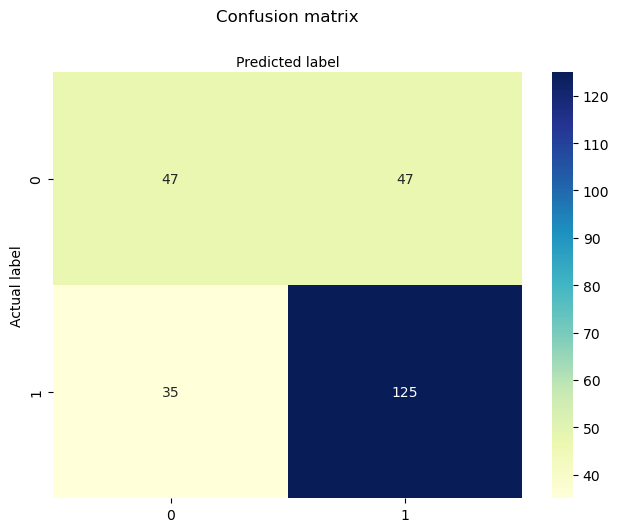

In [29]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

In [30]:
from sklearn.metrics import classification_report
target_names = ['Love brand', 'dont love']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Love brand       0.57      0.50      0.53        94
   dont love       0.73      0.78      0.75       160

    accuracy                           0.68       254
   macro avg       0.65      0.64      0.64       254
weighted avg       0.67      0.68      0.67       254



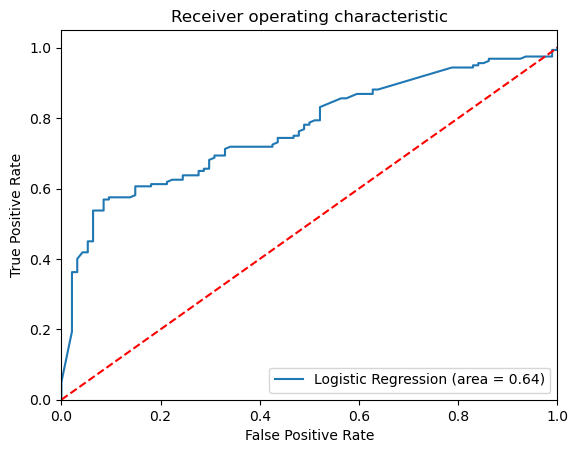

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test.astype(float), logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.astype(float), logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()